In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import RobustScaler


In [ ]:
# Plot settings
pd.set_option('display.max_columns', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW'
]

start_date = '2010-01-01'
end_date = '2025-03-31'


In [ ]:
#download data
def download_data(tickers, start, end):
    data = yf.download(tickers=tickers,
                       start=start,
                       end=end,
                       group_by='ticker',
                       auto_adjust=True,
                       progress=True)
    return data

raw_data = download_data(tickers, start_date, end_date)


[*********************100%***********************]  20 of 20 completed


In [ ]:
#preprpcessing
def preprocess_data(data, tickers, lookback=5):
    processed = {}

    for ticker in tickers:
        if ticker not in data:
            continue

        df = data[ticker].copy()

        if isinstance(df.index, pd.DatetimeIndex):
            df.index = df.index.tz_localize(None)

        df['Return'] = df['Close'].pct_change()
        df['Volatility'] = df['Return'].rolling(21).std()
        df['Dollar_Volume'] = df['Close'] * df['Volume']

        for lag in range(1, lookback + 1):
            df[f'Return_lag_{lag}'] = df['Return'].shift(lag)

        df['Target'] = df['Close'].pct_change(5).shift(-5)

        df = df.dropna()

        if len(df) > 100:
            processed[ticker] = df

    return processed

processed_data = preprocess_data(raw_data, tickers)


/tmp/ipython-input-5-1655839846.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
/tmp/ipython-input-5-1655839846.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Target'] = df['Close'].pct_change(5).shift(-5)
/tmp/ipython-input-5-1655839846.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
/tmp/ipython-inpu

In [ ]:
#Train XGBoost and Calculate RMSE / MAE

def train_models(processed_data, n_splits=3):
    models = {}
    metrics = []

    for ticker, df in processed_data.items():
        print(f"\nTraining model for {ticker}...")

        features = [col for col in df.columns if col.startswith(('Return', 'Volatility', 'Dollar')) and 'lag' not in col]
        X = df[features]
        y = df['Target']

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                objective='reg:squarederror',
                verbosity=0
            )
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)

            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)


            fold_scores.append({'RMSE': rmse, 'MAE': mae})

        avg_rmse = np.mean([s['RMSE'] for s in fold_scores])
        avg_mae = np.mean([s['MAE'] for s in fold_scores])
        best_fold_rmse = np.min([s['RMSE'] for s in fold_scores])

        models[ticker] = {
            'model': model,
            'scaler': scaler,
            'features': features,
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae
        }

        metrics.append({
            'Ticker': ticker,
            'Avg_RMSE': avg_rmse,
            'Best_Fold_RMSE': best_fold_rmse,
            'Avg_MAE': avg_mae
        })

    # Convert to DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Add overall averages row
    avg_row = {
        'Ticker': 'AVG_ALL',
        'Avg_RMSE': metrics_df['Avg_RMSE'].mean(),
        'Best_Fold_RMSE': metrics_df['Best_Fold_RMSE'].mean(),
        'Avg_MAE': metrics_df['Avg_MAE'].mean()}
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_row])], ignore_index=True)

    return models, metrics_df


In [ ]:
trained_models, model_metrics = train_models(processed_data)



Training model for AAPL...

Training model for MSFT...

Training model for NVDA...

Training model for AMZN...

Training model for GOOGL...

Training model for META...

Training model for TSLA...

Training model for BRK-B...

Training model for JPM...

Training model for V...

Training model for SAP.DE...

Training model for SIE.DE...

Training model for ALV.DE...

Training model for VOW3.DE...

Training model for LIN.DE...

Training model for MC.PA...

Training model for OR.PA...

Training model for AIR.PA...

Training model for ASML.AS...

Training model for NESN.SW...


In [ ]:
# Display sorted metrics table
display(model_metrics[model_metrics['Ticker'] != 'AVG_ALL'].sort_values('Avg_RMSE'))

# Show overall average row
print("\n🔍 Average Performance Across All Stocks:")
display(model_metrics[model_metrics['Ticker'] == 'AVG_ALL'])


,Ticker,Avg_RMSE,Best_Fold_RMSE,Avg_MAE
19,NESN.SW,0.024639,0.024092,0.018497
7,BRK-B,0.027572,0.021902,0.020670
16,OR.PA,0.032493,0.030755,0.024702
9,V,0.034646,0.033648,0.025686
10,SAP.DE,0.036850,0.032248,0.027676
12,ALV.DE,0.036875,0.031931,0.025408
14,LIN.DE,0.037608,0.002633,0.018640
1,MSFT,0.038694,0.035373,0.029246
8,JPM,0.039785,0.033372,0.029225
11,SIE.DE,0.040361,0.035653,0.030095



🔍 Average Performance Across All Stocks:


,Ticker,Avg_RMSE,Best_Fold_RMSE,Avg_MAE
20,AVG_ALL,0.046553,0.040516,0.03421


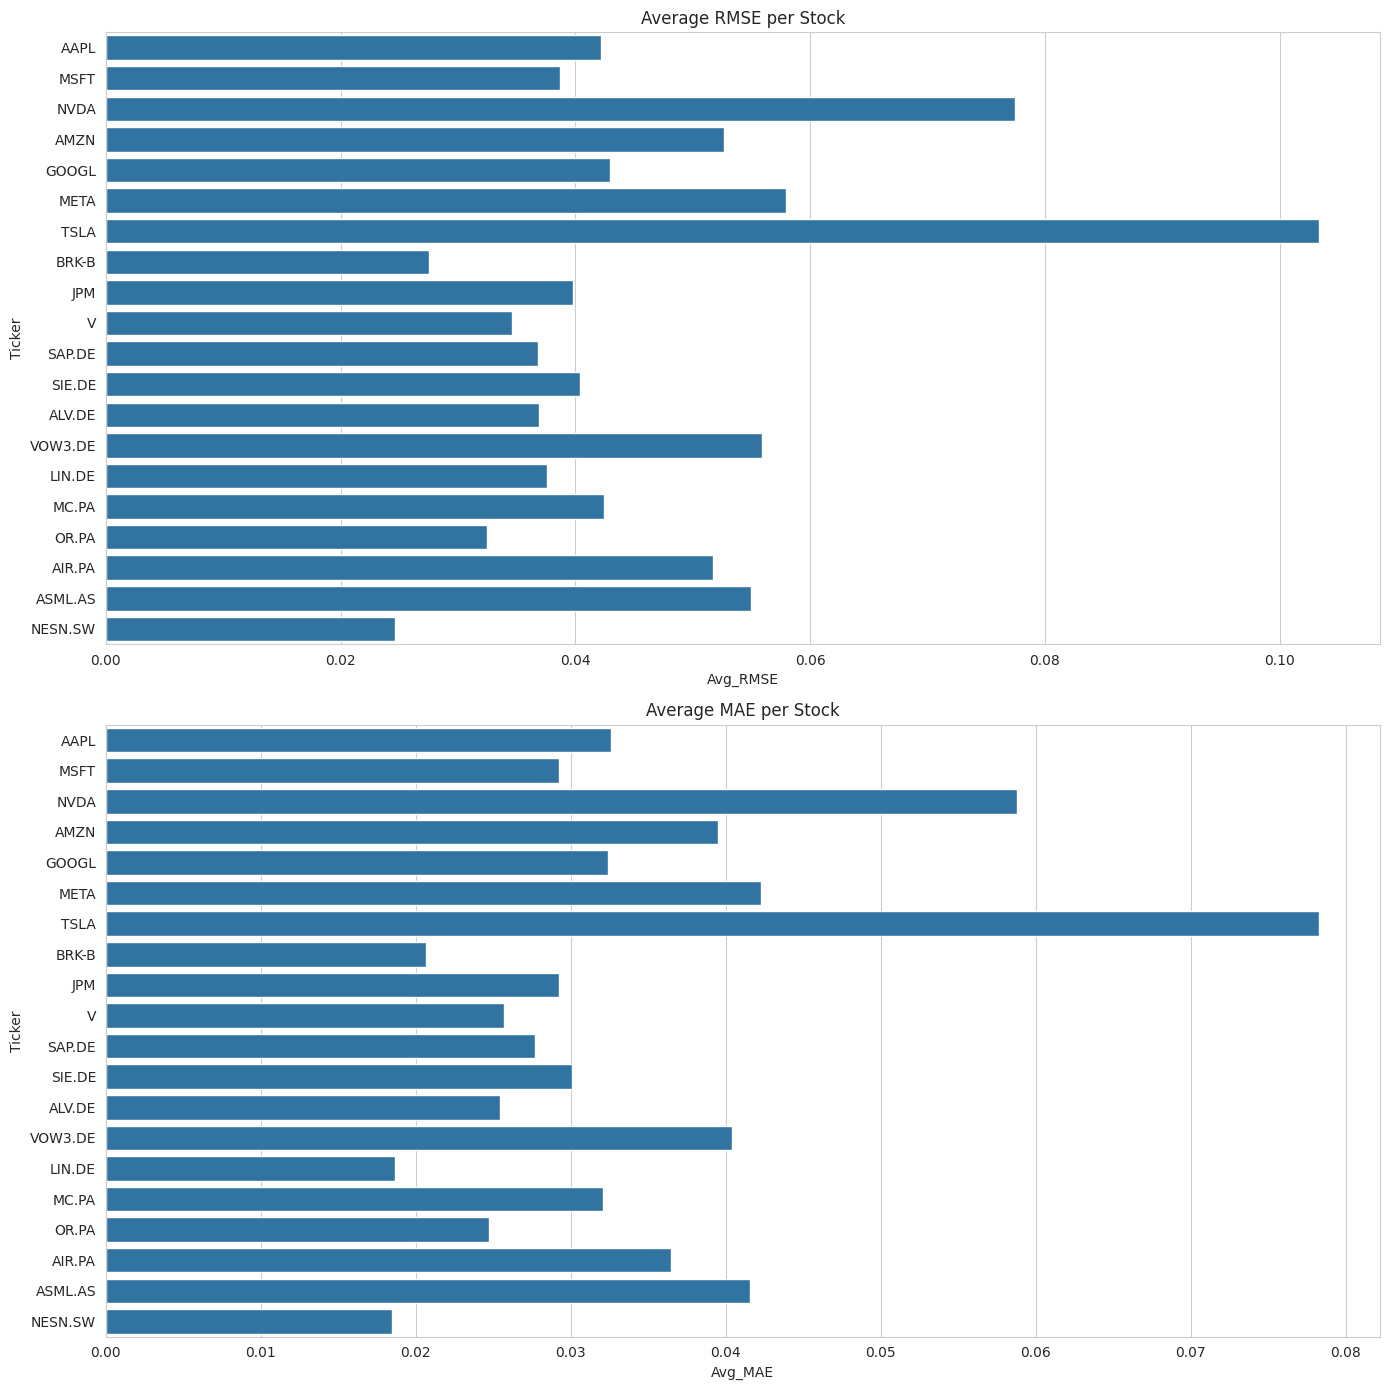

In [ ]:
plot_data = model_metrics[model_metrics['Ticker'] != 'AVG_ALL']

fig, axs = plt.subplots(2, 1, figsize=(14, 14))

sns.barplot(x='Avg_RMSE', y='Ticker', data=plot_data, ax=axs[0])
axs[0].set_title('Average RMSE per Stock')

sns.barplot(x='Avg_MAE', y='Ticker', data=plot_data, ax=axs[1])
axs[1].set_title('Average MAE per Stock')


plt.tight_layout()
plt.show()


In [ ]:
#plottingpred
def plot_predictions(ticker, trained_models, processed_data):
    if ticker not in trained_models or ticker not in processed_data:
        print(f"{ticker} not found in models or processed data.")
        return

    # Retrieve model and data
    model_info = trained_models[ticker]
    df = processed_data[ticker]

    X = df[model_info['features']]
    y = df['Target']
    X_scaled = model_info['scaler'].transform(X)
    preds = model_info['model'].predict(X_scaled)

    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, y, label='Actual 5-Day Return', alpha=0.7)
    plt.plot(df.index, preds, label='Predicted 5-Day Return', alpha=0.7)
    plt.title(f'{ticker} – Actual vs Predicted 5-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('5-Day Return')
    plt.legend()
    plt.grid(True)
    plt.show()


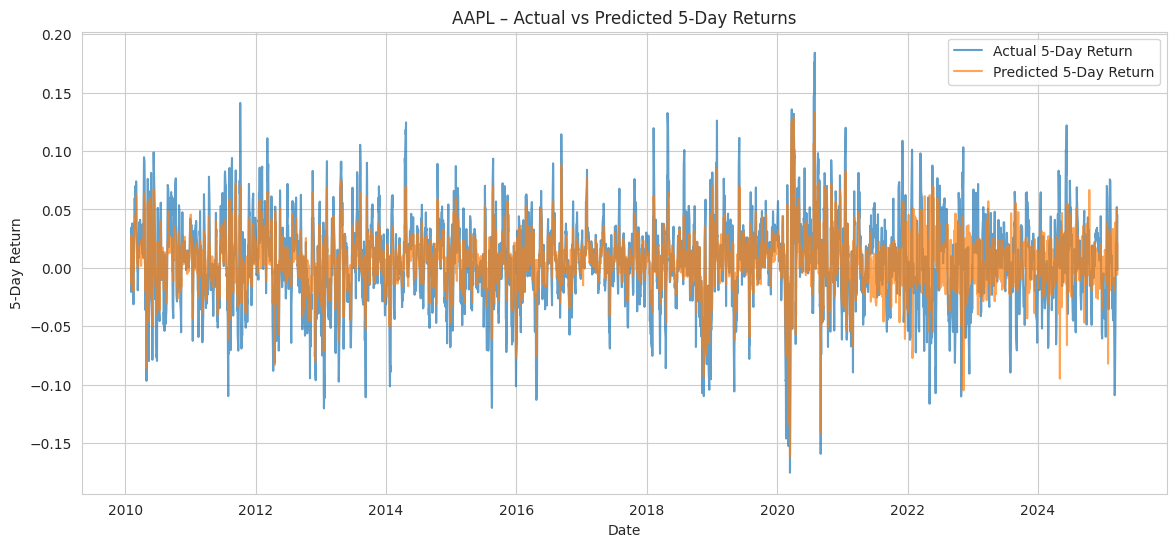

In [ ]:
plot_predictions('AAPL', trained_models, processed_data)


In [ ]:
#Lightgbm model
from lightgbm import LGBMRegressor


In [ ]:
def train_lightgbm_models(processed_data, n_splits=3):
    models = {}
    metrics = []

    for ticker, df in processed_data.items():
        print(f"\nTraining LightGBM for {ticker}...")

        # Select features
        features = [col for col in df.columns if col.startswith(('Return', 'Volatility', 'Dollar')) and 'lag' not in col]
        X = df[features]
        y = df['Target']

        # TimeSeries CV
        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_scores = []

        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Scaling
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # LightGBM Model
            model = LGBMRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=6,
                objective='regression',
                verbose=-1
            )
            model.fit(X_train_scaled, y_train)

            preds = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)

            fold_scores.append({'RMSE': rmse, 'MAE': mae})

        # Aggregate metrics
        avg_rmse = np.mean([s['RMSE'] for s in fold_scores])
        avg_mae = np.mean([s['MAE'] for s in fold_scores])
        best_fold_rmse = np.min([s['RMSE'] for s in fold_scores])

        models[ticker] = {
            'model': model,
            'scaler': scaler,
            'features': features,
            'avg_rmse': avg_rmse,
            'avg_mae': avg_mae
        }

        metrics.append({
            'Ticker': ticker,
            'Avg_RMSE': avg_rmse,
            'Best_Fold_RMSE': best_fold_rmse,
            'Avg_MAE': avg_mae
        })

    # Create DataFrame + AVG row
    metrics_df = pd.DataFrame(metrics)
    avg_row = {
        'Ticker': 'AVG_ALL',
        'Avg_RMSE': metrics_df['Avg_RMSE'].mean(),
        'Best_Fold_RMSE': metrics_df['Best_Fold_RMSE'].mean(),
        'Avg_MAE': metrics_df['Avg_MAE'].mean()
    }
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_row])], ignore_index=True)

    return models, metrics_df


In [ ]:
lgbm_models, lgbm_metrics = train_lightgbm_models(processed_data)



Training LightGBM for AAPL...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for MSFT...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for NVDA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for AMZN...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for GOOGL...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for META...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for TSLA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for BRK-B...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for JPM...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for V...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for SAP.DE...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for SIE.DE...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for ALV.DE...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for VOW3.DE...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for LIN.DE...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for MC.PA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for OR.PA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for AIR.PA...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


Training LightGBM for ASML.AS...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Training LightGBM for NESN.SW...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
display(lgbm_metrics.sort_values('Avg_RMSE'))


,Ticker,Avg_RMSE,Best_Fold_RMSE,Avg_MAE
19,NESN.SW,0.023910,0.022769,0.018100
7,BRK-B,0.026692,0.020760,0.019876
16,OR.PA,0.031532,0.029568,0.024119
9,V,0.034029,0.032628,0.025357
10,SAP.DE,0.035512,0.029853,0.026554
12,ALV.DE,0.035825,0.031211,0.024638
1,MSFT,0.036255,0.034360,0.027318
14,LIN.DE,0.036446,0.004675,0.017527
8,JPM,0.037506,0.031056,0.027910
11,SIE.DE,0.039661,0.034118,0.029411


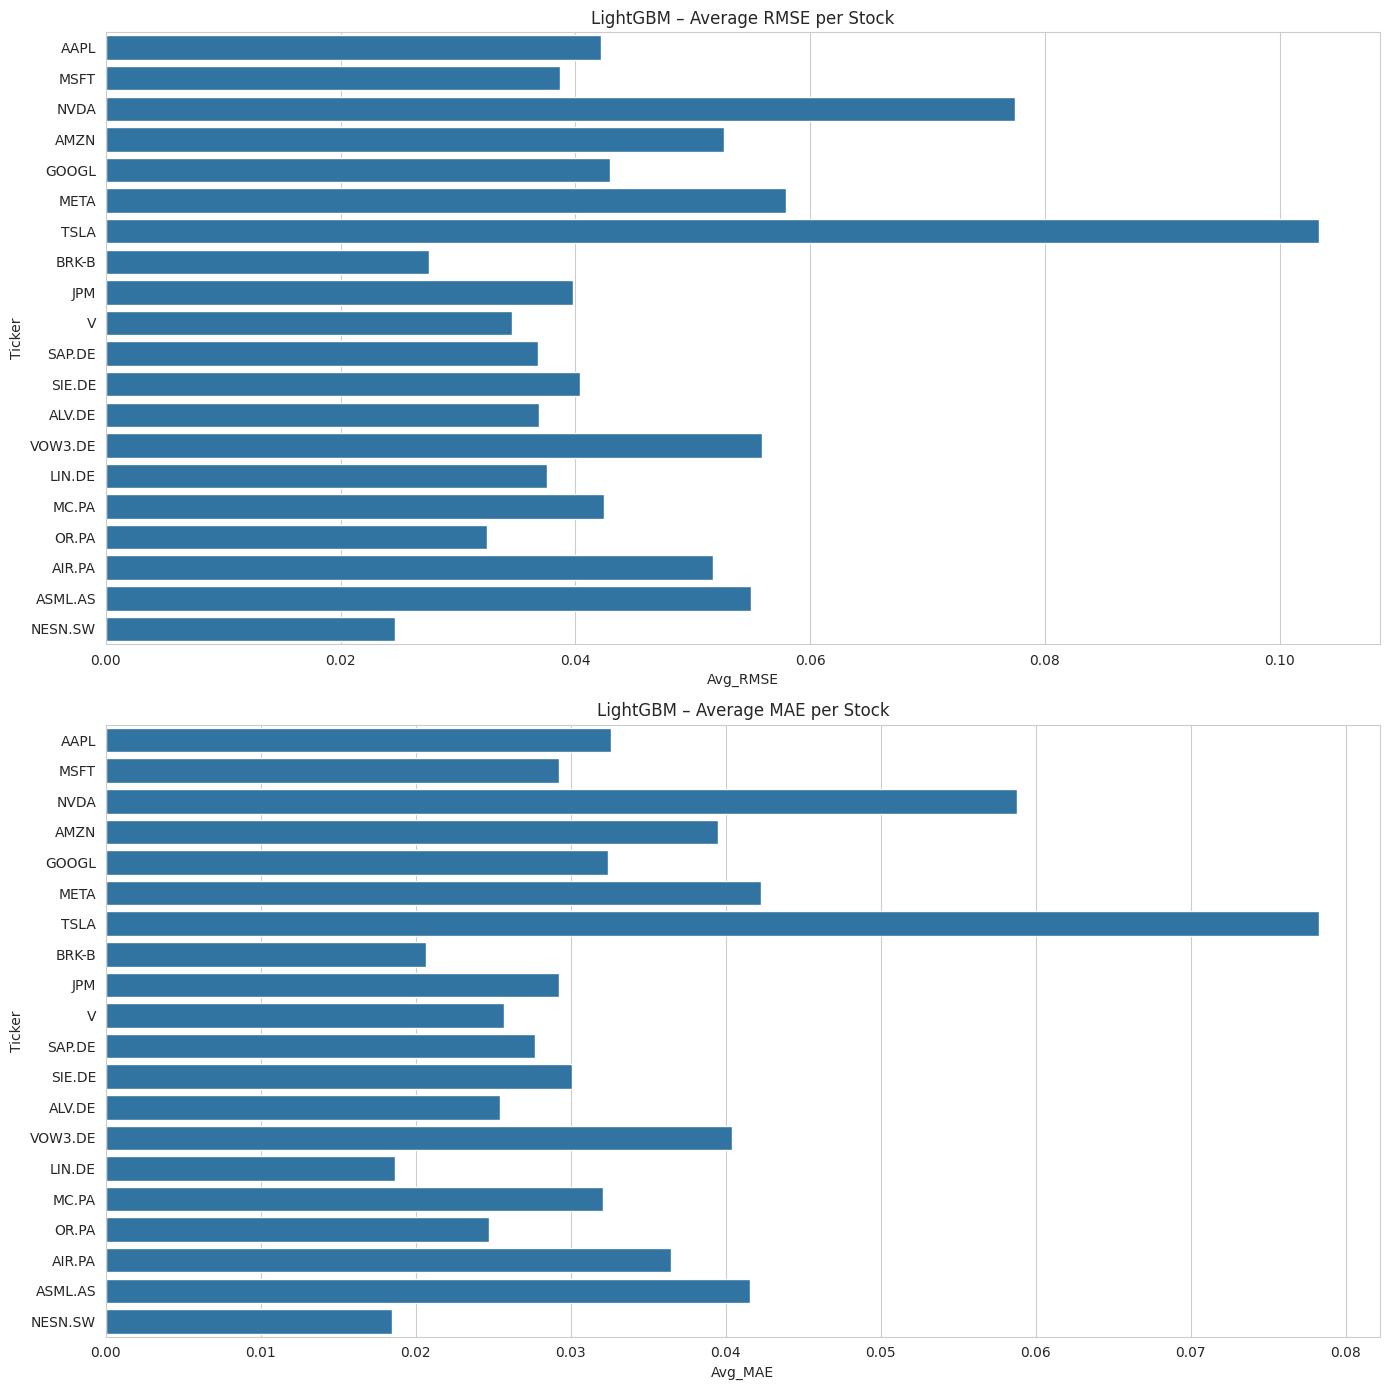

In [ ]:
# Exclude the "AVG_ALL" row if present
plot_data = model_metrics[model_metrics['Ticker'] != 'AVG_ALL']

fig, axs = plt.subplots(2, 1, figsize=(14, 14))

sns.barplot(x='Avg_RMSE', y='Ticker', data=plot_data, ax=axs[0])
axs[0].set_title('LightGBM – Average RMSE per Stock')

sns.barplot(x='Avg_MAE', y='Ticker', data=plot_data, ax=axs[1])
axs[1].set_title('LightGBM – Average MAE per Stock')

plt.tight_layout()
plt.show()


In [ ]:
def plot_predictions_lightgbm(ticker, trained_models, processed_data):
    if ticker not in trained_models or ticker not in processed_data:
        print(f"{ticker} not found in models or processed data.")
        return

    # Retrieve model and data
    model_info = trained_models[ticker]
    df = processed_data[ticker]

    X = df[model_info['features']]
    y = df['Target']
    X_scaled = model_info['scaler'].transform(X)
    preds = model_info['model'].predict(X_scaled)

    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, y, label='Actual 5-Day Return', alpha=0.7)
    plt.plot(df.index, preds, label='Predicted 5-Day Return', alpha=0.7)
    plt.title(f'{ticker} – LightGBM Actual vs Predicted 5-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('5-Day Return')
    plt.legend()
    plt.grid(True)
    plt.show()


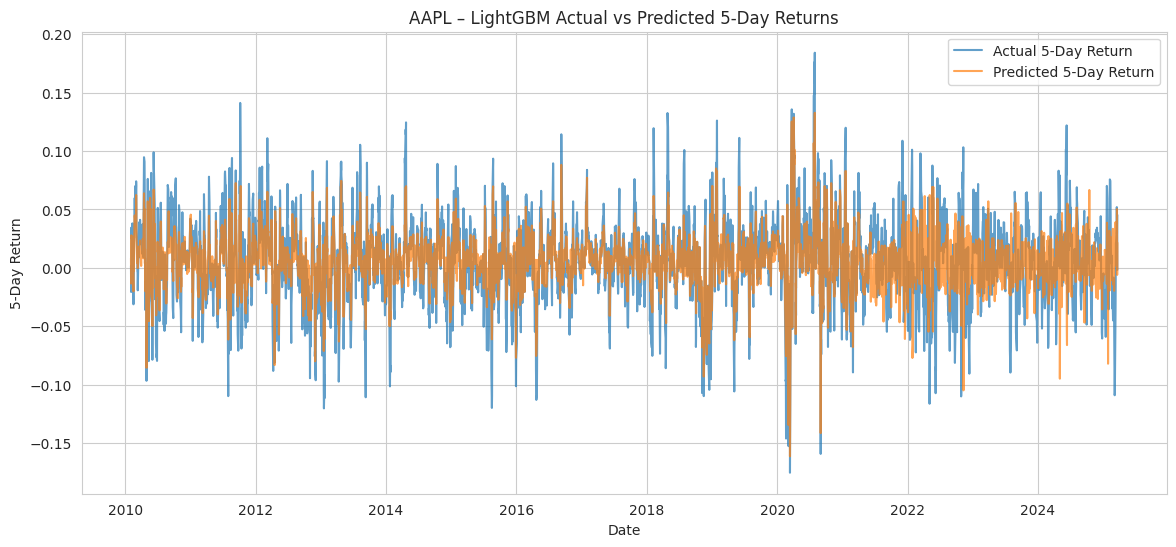

In [ ]:
plot_predictions_lightgbm('AAPL', trained_models, processed_data)


In [ ]:
xgb_metrics = model_metrics.copy()
xgb_metrics['Model'] = 'XGBoost'

lgbm_metrics['Model'] = 'LightGBM'

combined_metrics = pd.concat([xgb_metrics, lgbm_metrics], ignore_index=True)


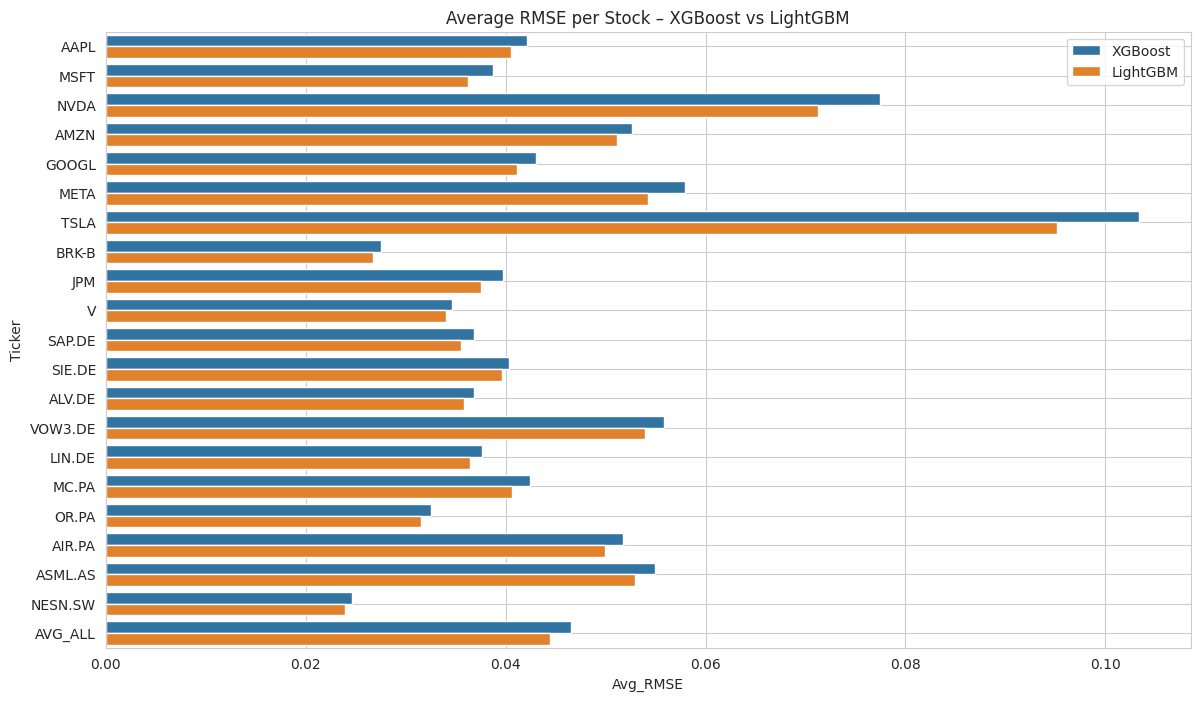

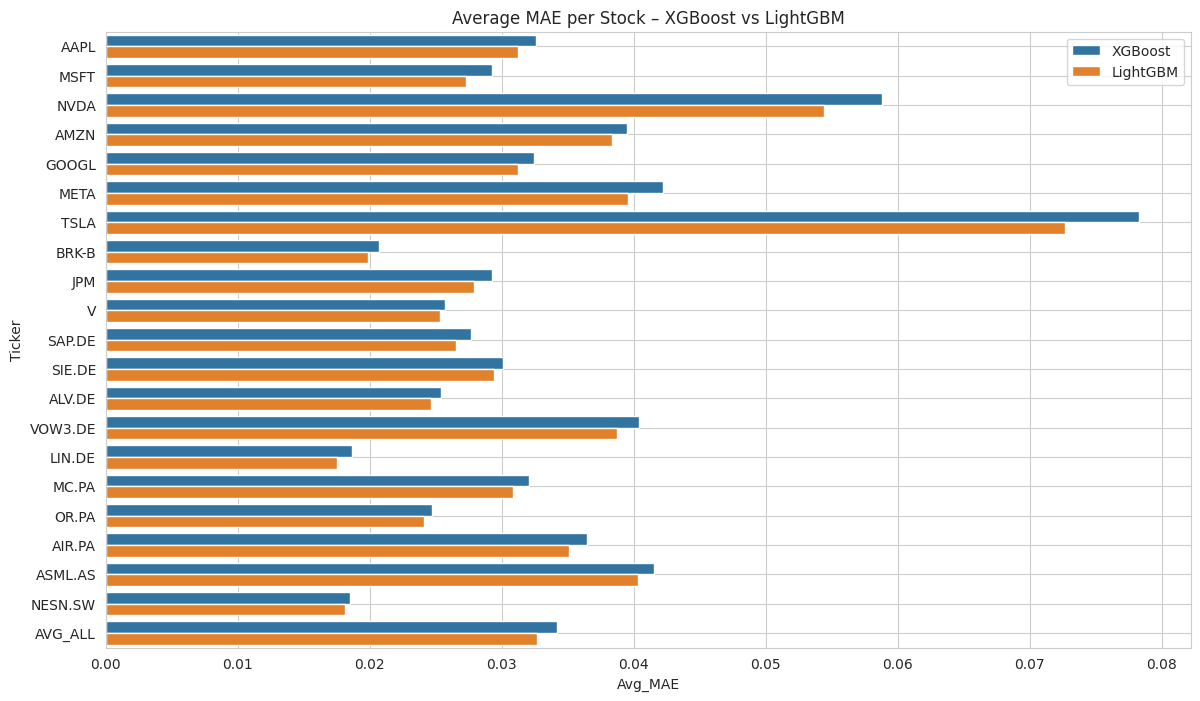

In [ ]:
# Barplot for RMSE comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Avg_RMSE', y='Ticker', hue='Model', data=combined_metrics)
plt.title('Average RMSE per Stock – XGBoost vs LightGBM')
plt.legend()
plt.grid(True)
plt.show()

# Barplot for MAE comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Avg_MAE', y='Ticker', hue='Model', data=combined_metrics)
plt.title('Average MAE per Stock – XGBoost vs LightGBM')
plt.legend()
plt.grid(True)
plt.show()